# ISIDORA-PYX

In [1]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ic = %env ICDIR

In [4]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [7]:
from system_of_units import *

In [8]:
from Util import *

In [9]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [10]:
from Configure import *

In [11]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [13]:
from scipy import signal as SGN 

In [24]:
import time

In [19]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [20]:
import cProfile

### ISIDORA-PYX revisited on:

In [25]:
print(time.strftime("%d/%m/%Y"))

03/10/2016


In [26]:
print(time.strftime("%H:%M:%S"))

15:21:14


### BLR

#### Deconvolution function

In [32]:
class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sgn_raw = FP.ceiling - pmtrd[event_number, j]
        sblr = BLR(sgn_raw, coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS

### Cython version

In [ ]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR_cy(float [:] signal_daq, folat[:] coef, int mau_len=250, float thr1, float thr2):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sgn_raw = FP.ceiling - pmtrd[event_number, j]
        sblr = BLR(sgn_raw, coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS

### ISIDORA

In [93]:
def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])
    
    if INFO:
        
    
        print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    
    PATH_IN=CFP['PATH_IN'] 
    FILE_IN=CFP['FILE_IN']
    FIRST_EVT=CFP['FIRST_EVT']
    LAST_EVT=CFP['LAST_EVT']
    RUN_ALL=CFP['RUN_ALL']
    COEF=CFP['COEF']
    CA=farray_from_string(CFP['CA'])*nF 
    AC=farray_from_string(CFP['AC']) 
    MAU_LEN=CFP['MAU_LEN']
    NSIGMA1=CFP['NSIGMA1'] 
    NSIGMA2=CFP['NSIGMA2'] 
    NSIGMA3=CFP['NSIGMA3'] 

    NEVENTS = LAST_EVT -  FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    print("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    print("MAU length = {} n_sigma1 = {} n_sigma2 = {} n_sigma3 = {} ".format(
        MAU_LEN,NSIGMA1,NSIGMA2, NSIGMA3))
    print("CA  = {} nF ".format(CA/nF))
    print("Accumulator Coefficients = {}  ".format(AC))
    

    # open the input file in mode append 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "a") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.RD.pmtrwf     #PMT raw data must exist

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)    
        
        NPMT = pmtrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        NEVENTS_DST = pmtrd_.shape[0]

        print("nof PMTs = {} nof events in input DST = {} ".format(
        NPMT,NEVENTS_DST))

        print("lof PMT WF (MC) = {} ".format(
        PMTWL))

        #wait()
            
        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        pmtcwf =0
        try:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration 
        # mau, acummulator, pulse_on and wait_over stored for pmt 0
        # baseline stored for all PMTs.

        rgroup = 0
        try:
            rgroup = h5in.root.BLR
            
        except tables.exceptions.NodeError:
            rgroup = h5in.create_group(h5in.root, "BLR")
        
        mau = 0
        acum = 0
        pulse_on = 0
        wait_over = 0
        baseline = 0

        try:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            acum  = h5in.root.BLR.acum 
            h5in.remove_node("/BLR","acum")
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            baseline  = h5in.root.BLR.baseline 
            h5in.remove_node("/BLR","baseline")
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

        
        # cofficients of accumulator
        coeff_acc = AC
        if COEF == 0:
            print("computing the accumulator coefficients from nominal capacitances")
            coeff_acc = accumulator_coefficients(pmtrd_,CA) 
            print("AC = {}".format(coeff_acc))


        #LOOP
        first_evt, last_evt = define_event_loop(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST,RUN_ALL)
            
        t0 = time()
        for i in range(first_evt,last_evt):
            
            logger.info("-->event number ={}".format(i))

            #DBLR
            
            BLRS = DBLR(pmtrd_, i, coeff_acc, mau_len=MAU_LEN,
                        thr1 = NSIGMA1*FP.NOISE_ADC, thr2=NSIGMA2*FP.NOISE_ADC, 
                        thr3 = NSIGMA3*FP.NOISE_ADC, log=DEBUG_LEVEL)

            
            pmtCWF = []
            for blr in BLRS:
                pmtCWF.append(blr.signal_r)
                
            #append to pmtcwd
            pmtcwf.append(np.array(pmtCWF).reshape(1, NPMT, PMTWL))

            # append BLR variables
            
            
            BASELINE = []
            for blr in BLRS:
                BASELINE.append(blr.BASELINE)
            baseline.append(np.array(BASELINE).reshape(1, NPMT))

            mau_pmt0 = BLRS[0].MAU
            mau.append(mau_pmt0.reshape(1, PMTWL))

            pulse_on0 = BLRS[0].pulse_on
            pulse_on.append(pulse_on0.reshape(1, PMTWL))

            wait_over0 = BLRS[0].wait_over
            wait_over.append(wait_over0.reshape(1, PMTWL))

            acum0  = BLRS[0].acum
            acum.append(acum0.reshape(1, PMTWL))
                
        t1 = time()
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()
        acum.flush()
        baseline.flush()
        
        print("ISIDORA has run over {} events in {} seconds".format(i, t1-t0))
    print("Leaving ISIDORA. Safe travels!")

### Understanding the BLR parameters

The BLR algorithm is controlled by 3 threshold:
1. thr1 controls when the pulse starts and ends:
2. thr3 controls when the raw signal reaches baseline
3. thr2 is an auxiliare threshold which can, in principle bet set to zero.

In more detail, thr1 works as follows

Once pulse_on = 1 the BLR algorithm freezes the MAU (the baseline) and starts recovering signal

The pulse finishes (pulse_on = 0) when the recovered signal falls below trigger line (which is controlled by the baseline and thr1). An additional thr2 can be set to refine this condition but choosing values of thr1 sufficiently large (e.g, 5 x sigma x noise) should make thr2 not necessary (thus thr2 = 0).

Tail compensation is needed to recover the baseline as soon as possible, since another signal can come at any time, but once the recovered signal has dropped below trigger line its energy is fixed. The tail compensation condition is as follows:

If thr3 is zero or too low, often the tail never compensates. Setting it sufficiently large forces the signal to return to baseline, sometimes with a small jump (which should be irrelevant, since the recovered signal is over).

### Tuning parameters

#### "old" Na-22 file

#### thr1 = 5 x sigma, thr2 = 0 x sigma, thr3 = 0 x sigma

In [304]:
h5f.close()

In [306]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 0.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.45076179504 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.43 s, sys: 38.6 ms, total: 2.47 s
Wall time: 2.52 s


In [313]:
def cwf(event=0, pmt=0):
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
    pmtcwf = h5f.root.RD.pmtcwf
    pmtcw = pmtcwf[event, pmt]
    pulse_on = h5f.root.BLR.pulse_on[event]
    wait_over = h5f.root.BLR.wait_over[event]
    acum  = h5f.root.BLR.acum[event] 
    plts(pmtcw, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pulse_on, signal_start=0, signal_end=25000, offset=1)
    plts(wait_over, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5000, signal_end=5500, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5700, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=6000, signal_end=9000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=7500, signal_end=9000, offset=1)
    plt.show()
    h5f.close()
    

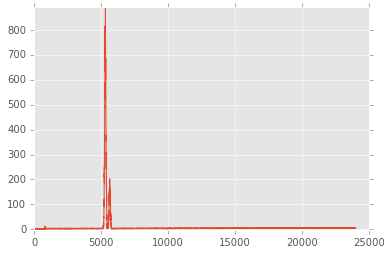

Press a key...


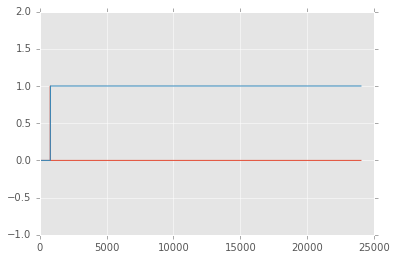

Press a key...


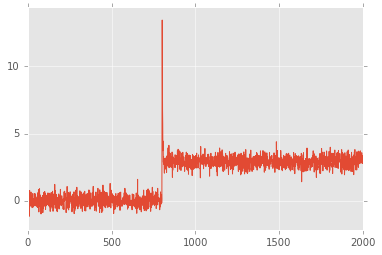

Press a key...


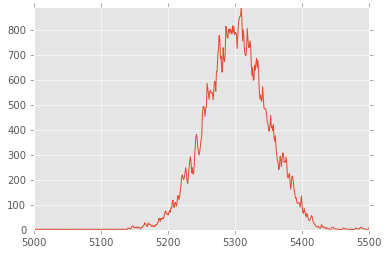

Press a key...


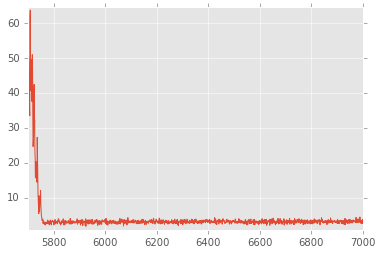

Press a key...


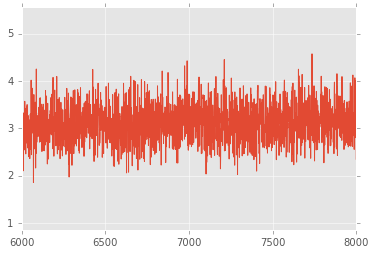

Press a key...


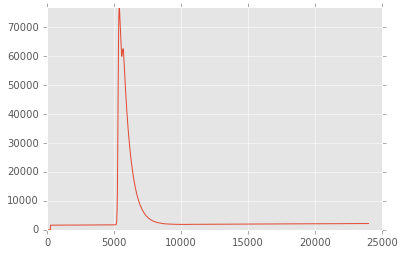

Press a key...


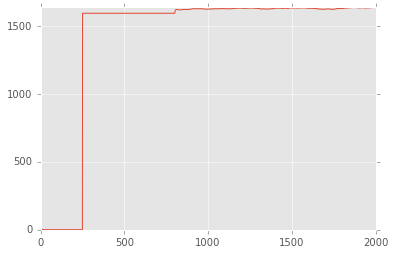

Press a key...


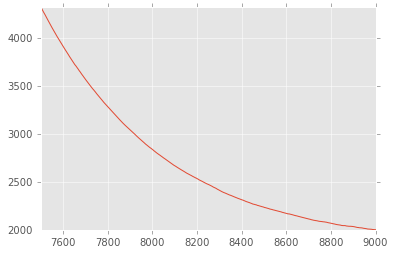

In [308]:
cwf()

#### With nsigma (5,0,0)  the baseline is never fully recovered

### Case (5,0,1)

In [309]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 1.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.9679889679 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.97 s, sys: 37.9 ms, total: 3.01 s
Wall time: 3.03 s


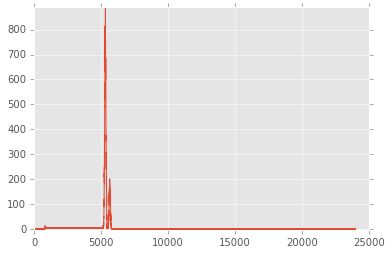

Press a key...


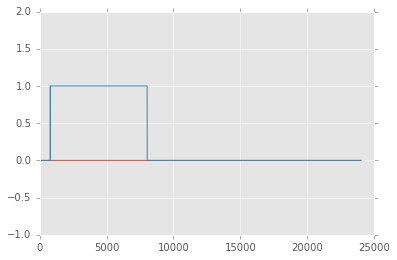

Press a key...


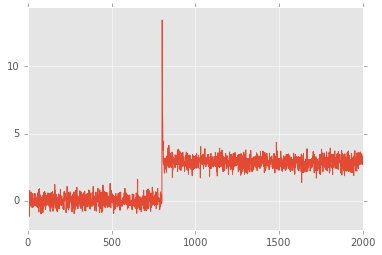

Press a key...


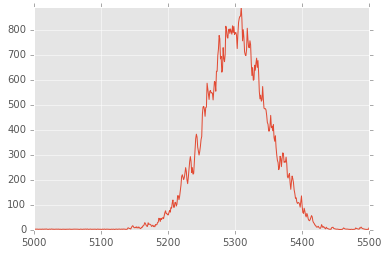

Press a key...


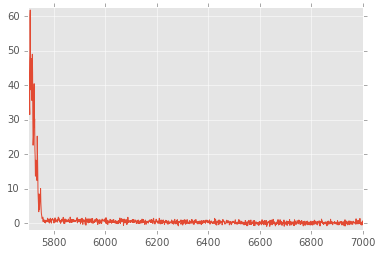

Press a key...


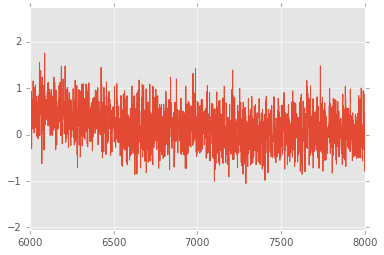

Press a key...


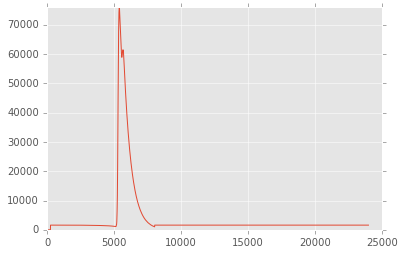

Press a key...


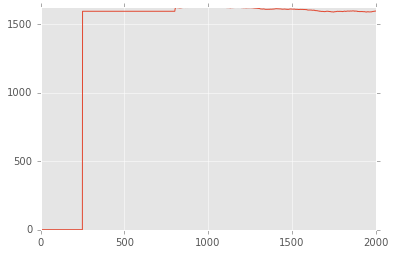

Press a key...


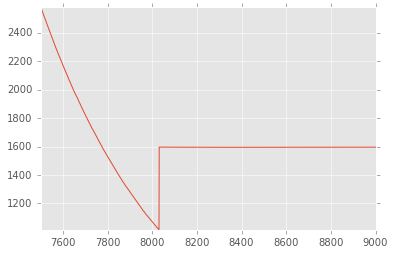

In [310]:
cwf()

#### Case (5,0,1):  The baseline returns to zero by S1 is distorted.

###  Case(5,0,2)

In [311]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 3.0748860836 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 3.07 s, sys: 40.8 ms, total: 3.11 s
Wall time: 3.14 s


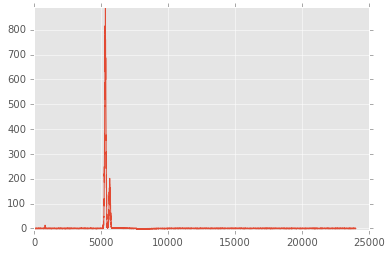

Press a key...


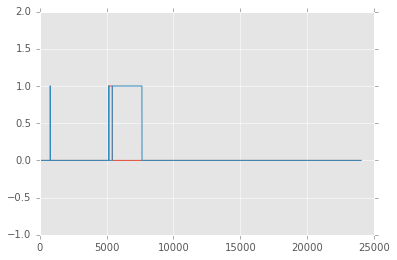

Press a key...


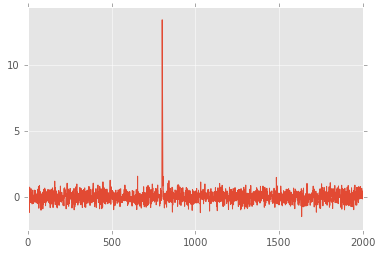

Press a key...


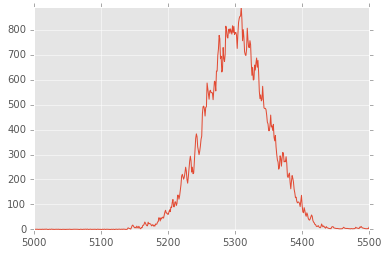

Press a key...


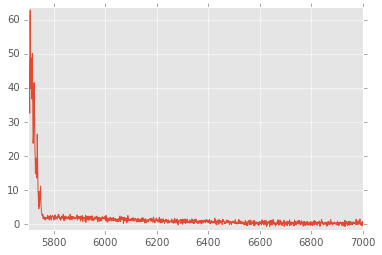

Press a key...


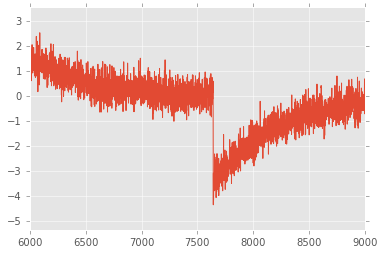

Press a key...


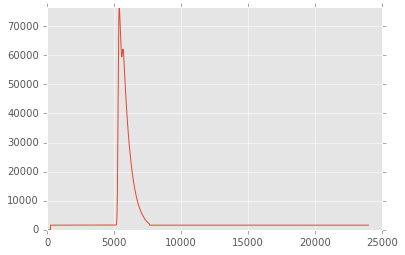

Press a key...


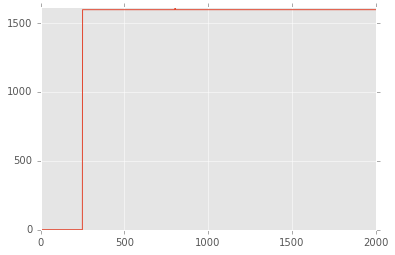

Press a key...


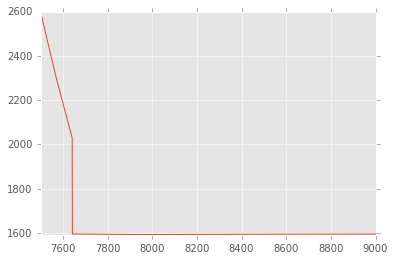

In [314]:
cwf()

### C(5,0,2): S1 is not distorted, wait_over is minimized.

### Test run over 10 events

In [315]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 31.8485651016 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 31.1 s, sys: 455 ms, total: 31.6 s
Wall time: 32 s


In [316]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
pmtcwf = h5f.root.RD.pmtcwf

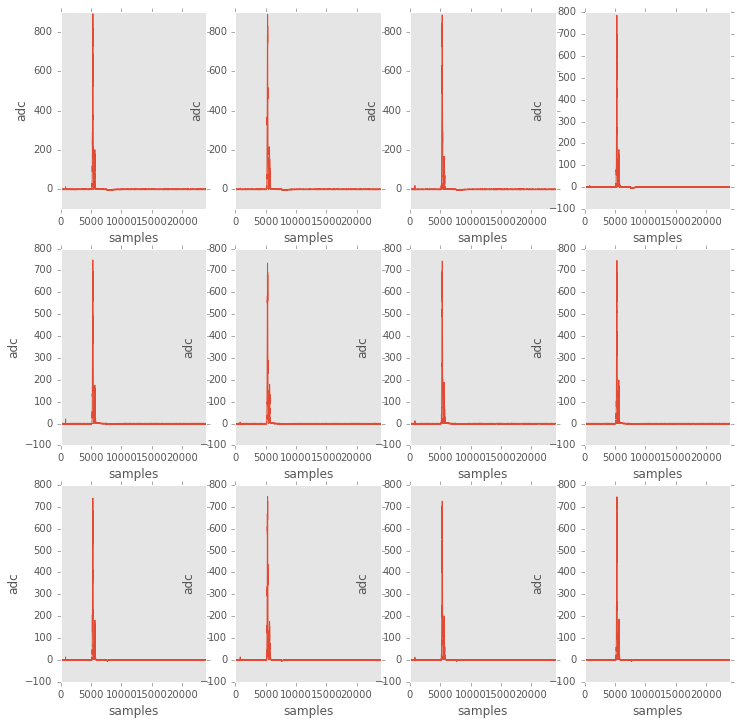

Press a key...


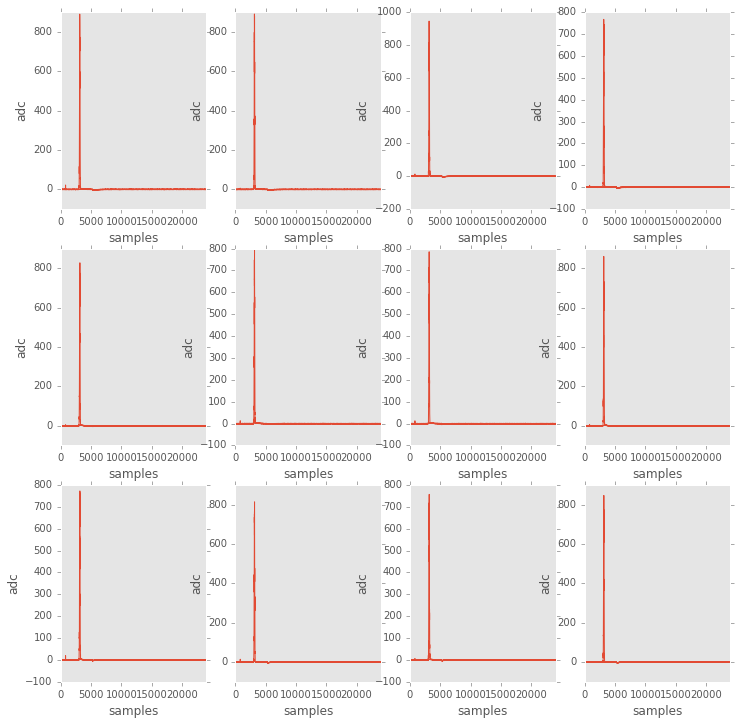

Press a key...


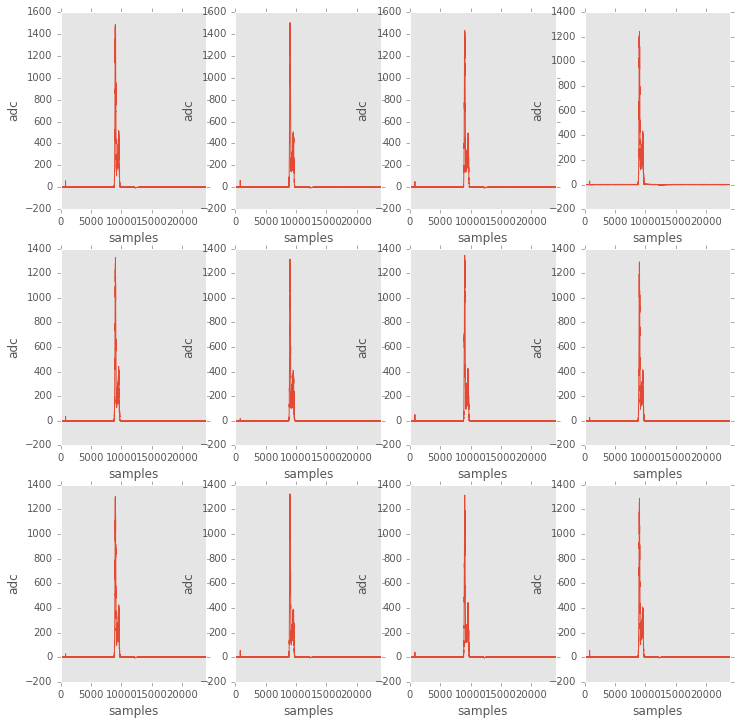

Press a key...


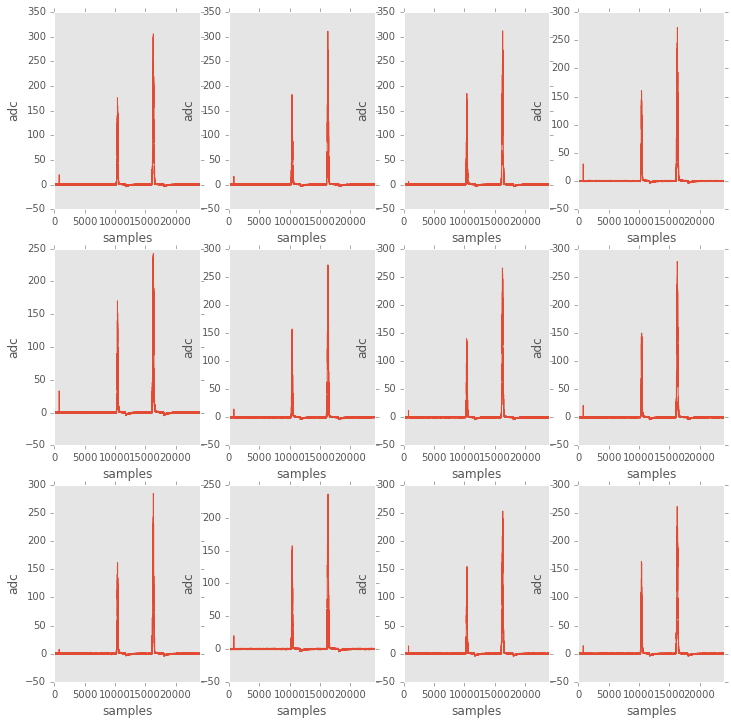

Press a key...


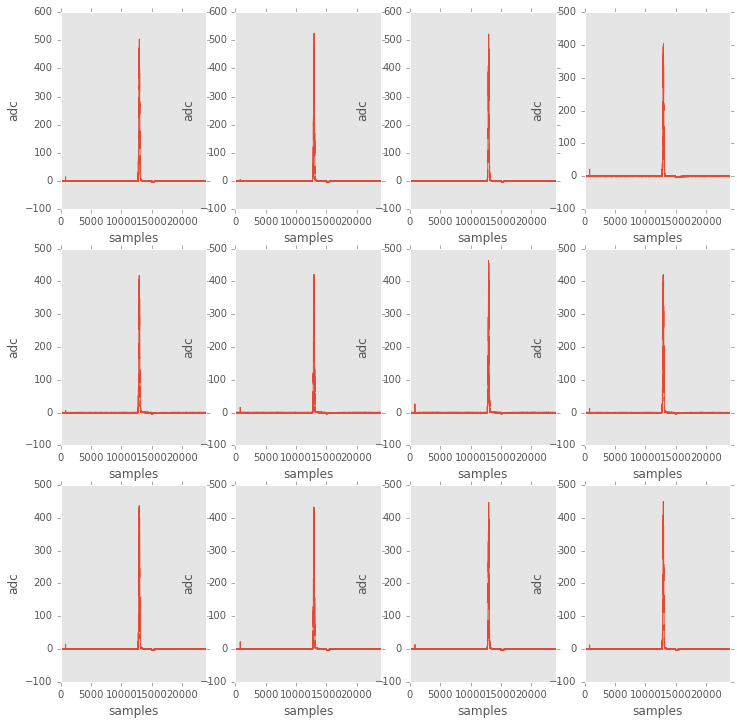

Press a key...


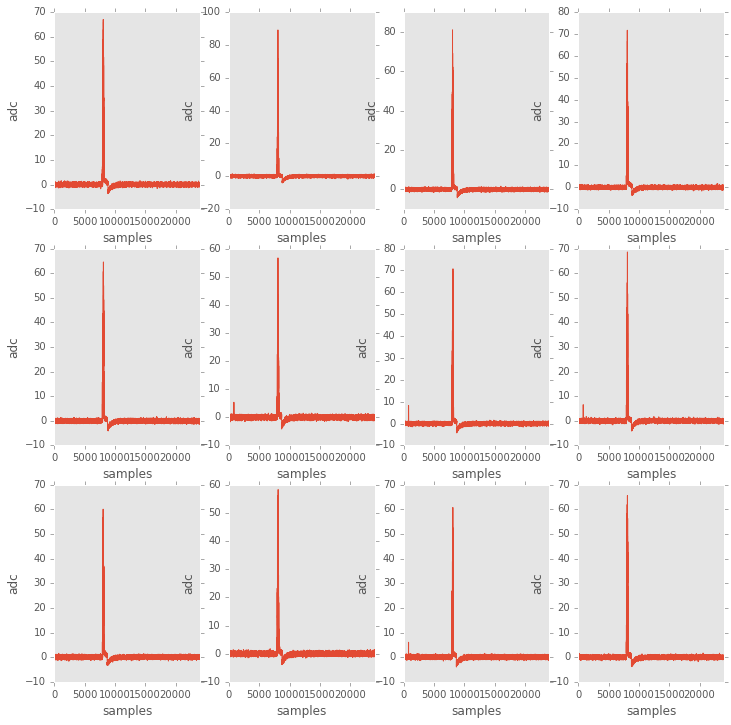

Press a key...


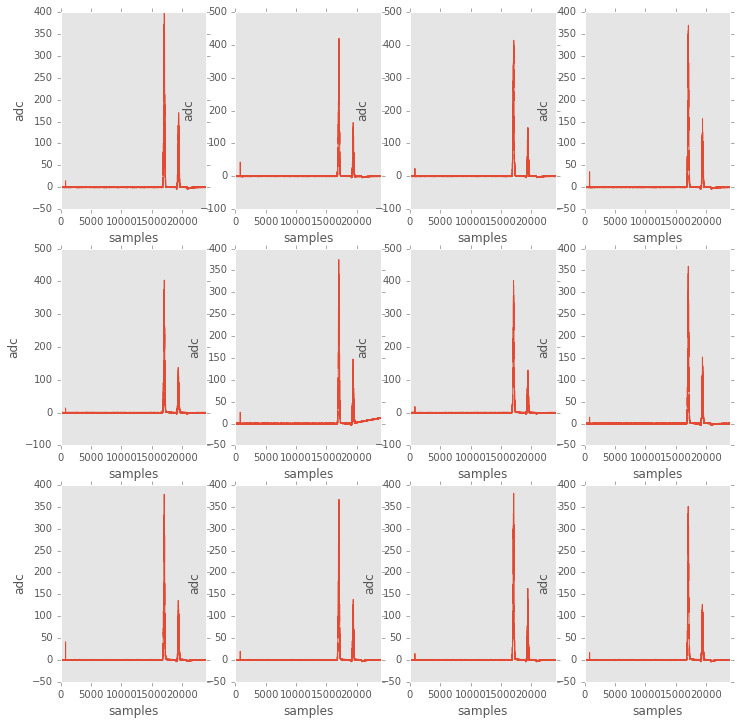

Press a key...


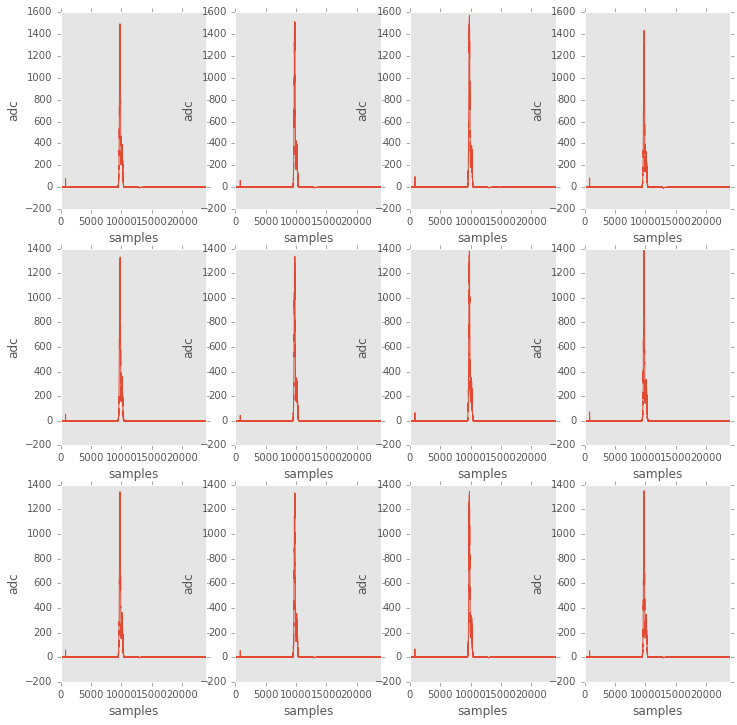

Press a key...


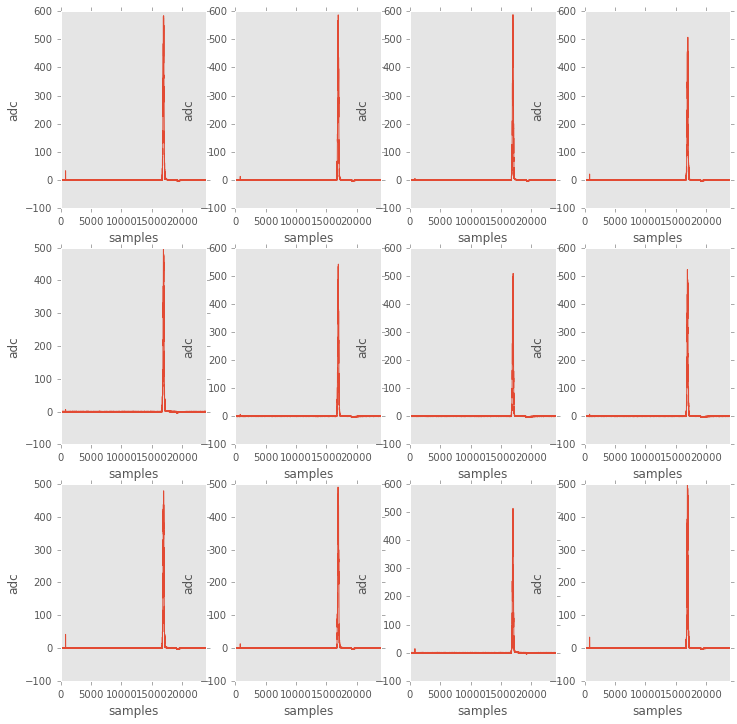

Press a key...


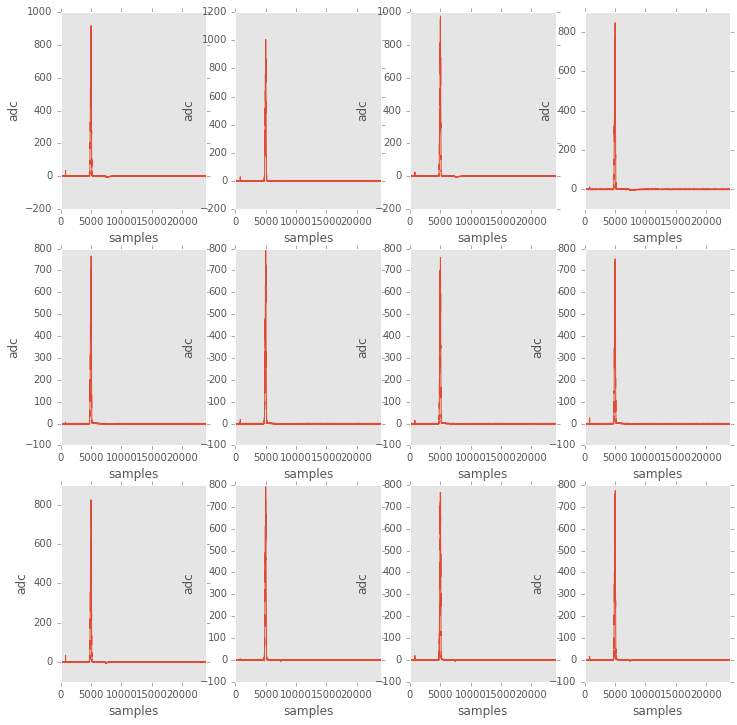

Press a key...


In [317]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

### Test run over new preproc Kr file

In [320]:
h5f.close()

In [322]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5','r+')

In [323]:
pmtrwf = h5f.root.RD.pmtrwf

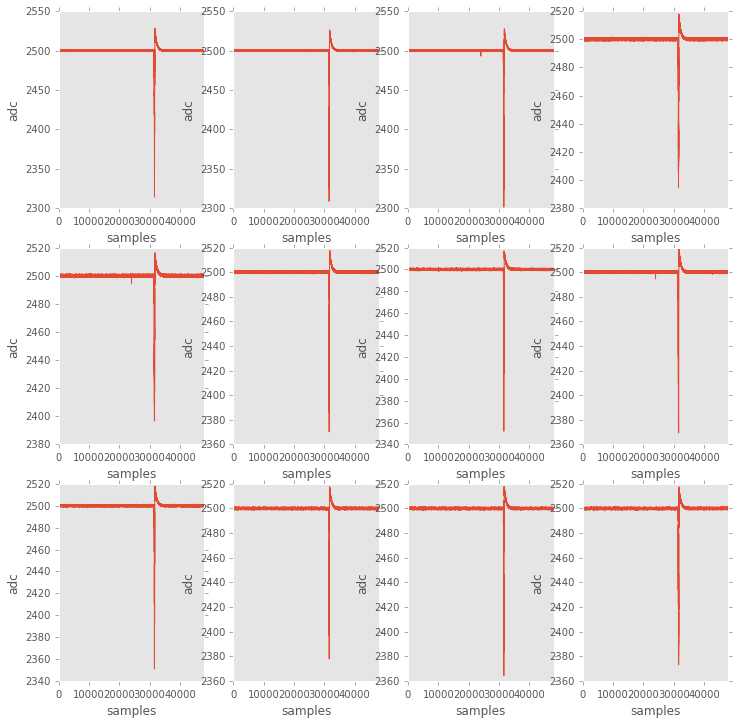

Press a key...


In [324]:
mpl.scan_waveforms(pmtrwf,list_of_events=[0])

In [325]:
h5f.close()

In [326]:
%less ../../Config/ISIDORA_NA_ZLIB_test.csv

### C(5,0,2)

In [346]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 6.16009998322 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 6.13 s, sys: 119 ms, total: 6.25 s
Wall time: 6.26 s


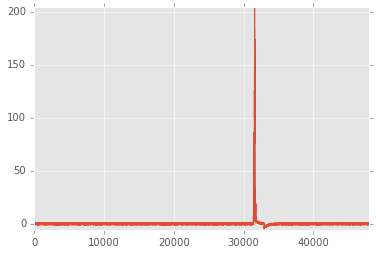

In [347]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf
pulse_on = h5f.root.BLR.pulse_on[0]
wait_over = h5f.root.BLR.wait_over[0]
acum  = h5f.root.BLR.acum[0] 
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=0, signal_end=48000, offset=1)

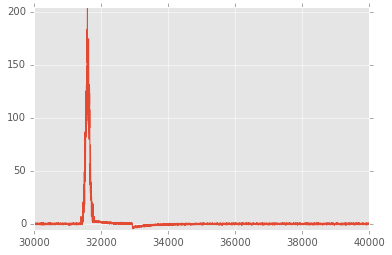

In [349]:
plts(pmtcw, signal_start=30000, signal_end=40000, offset=1)

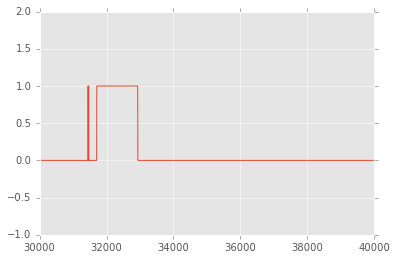

In [350]:
plts(wait_over, signal_start=30000, signal_end=40000, offset=1)

### Running 10 events

In [351]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 61.3548669815 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 1min, sys: 799 ms, total: 1min 1s
Wall time: 1min 1s


In [353]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf

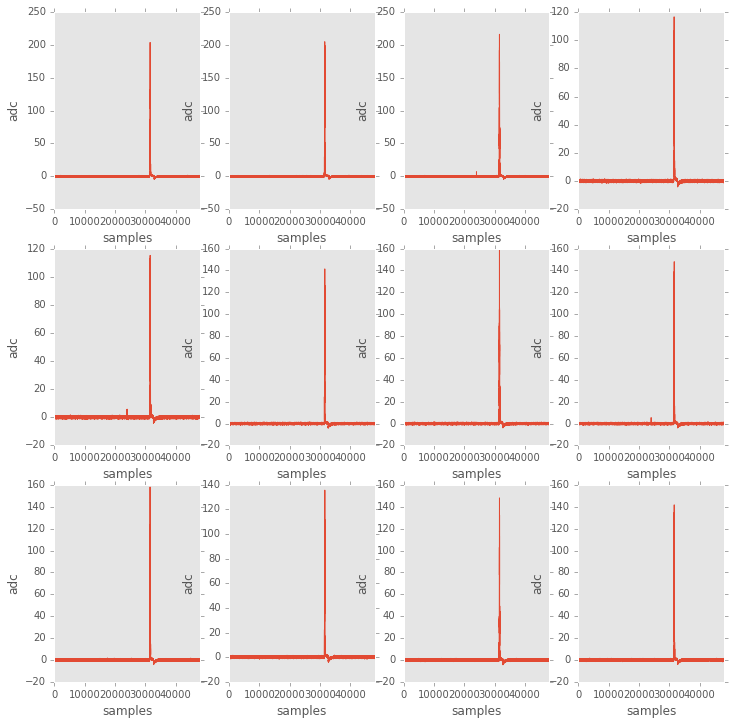

Press a key...


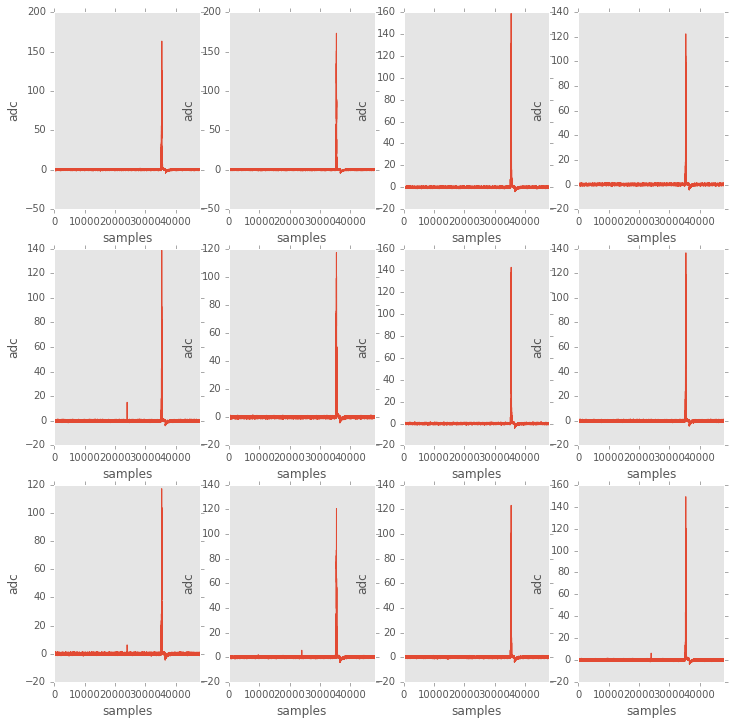

Press a key...


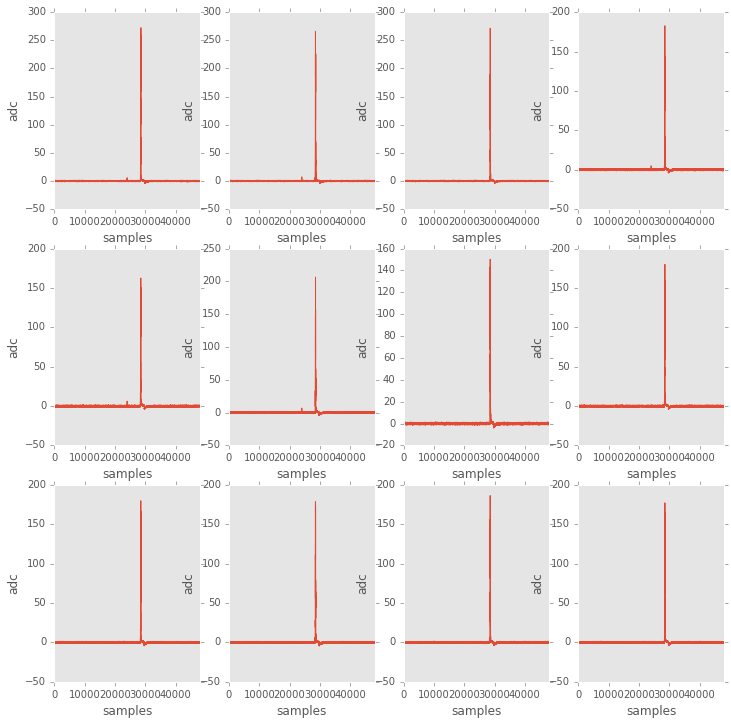

Press a key...


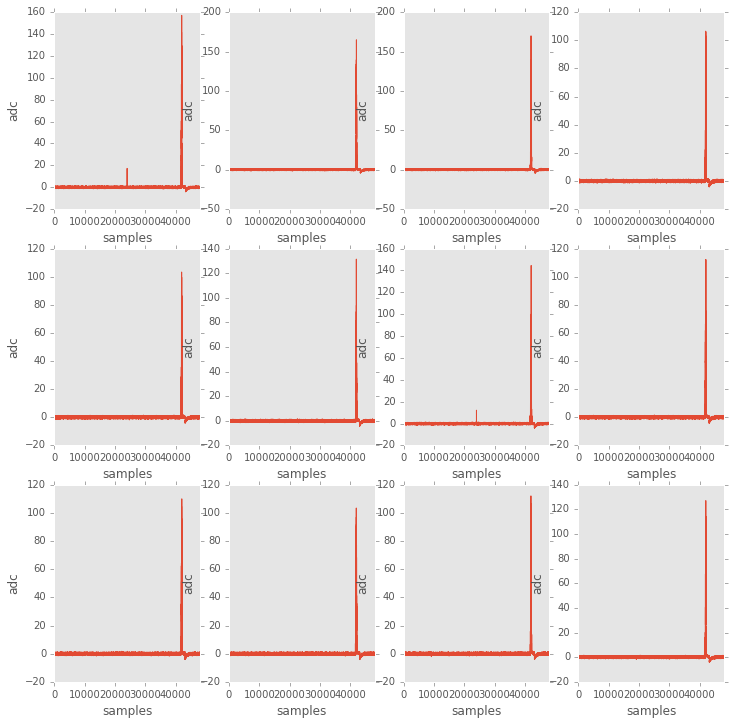

Press a key...


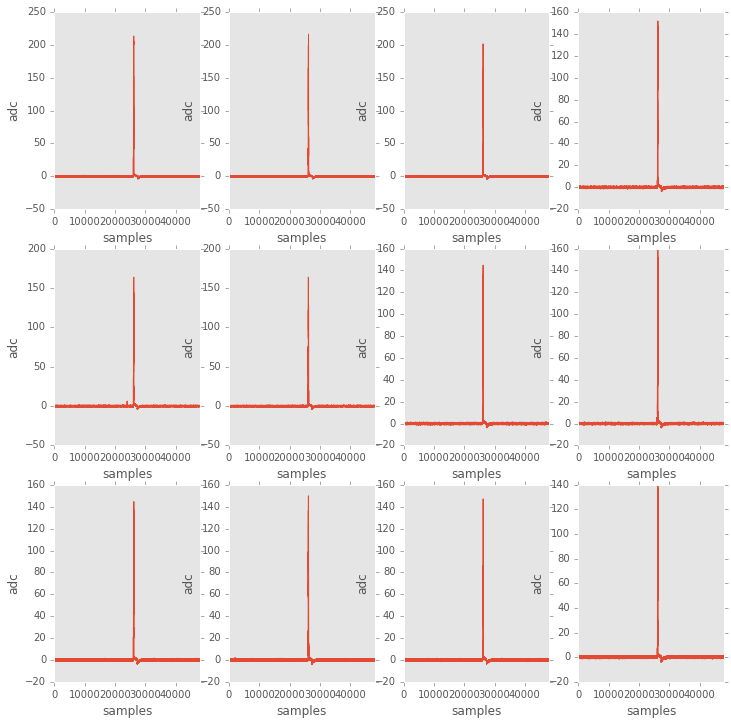

Press a key...


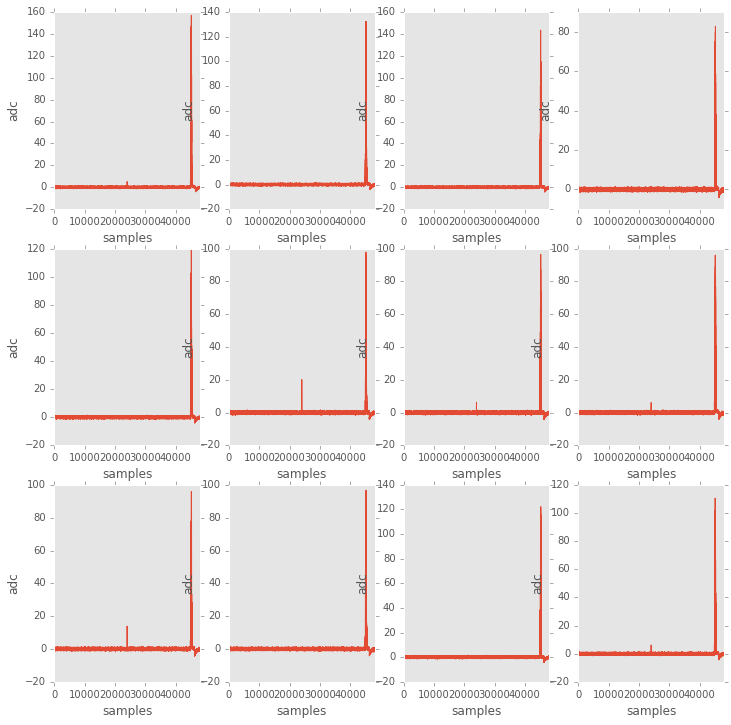

Press a key...


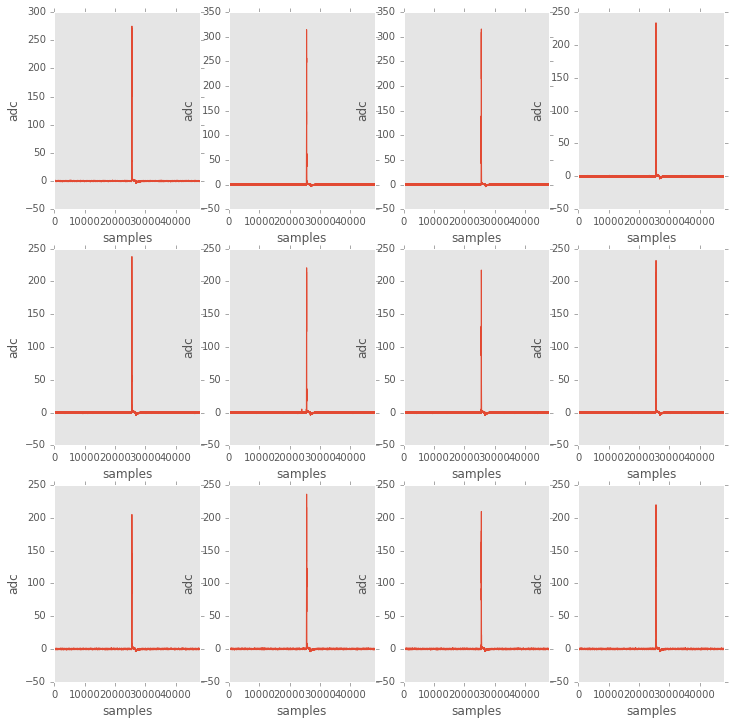

Press a key...


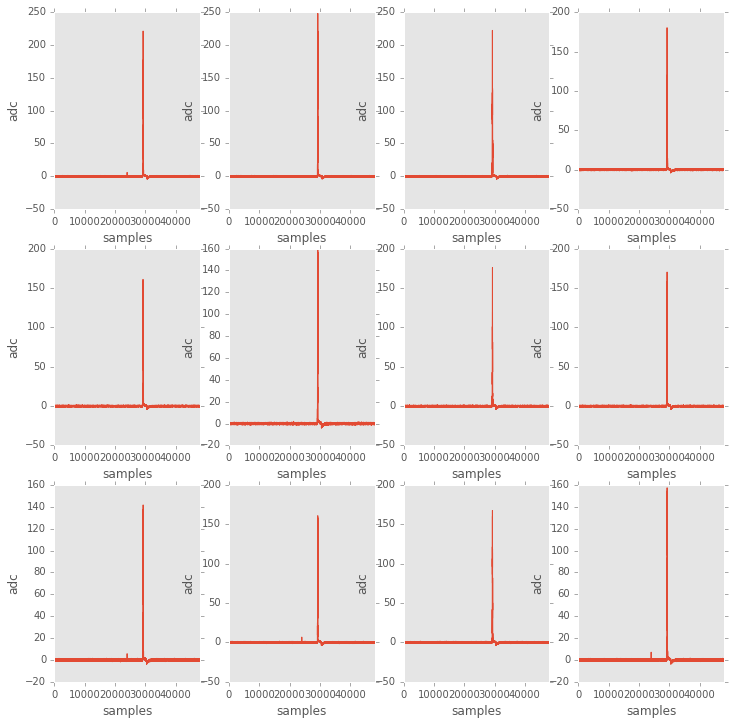

Press a key...


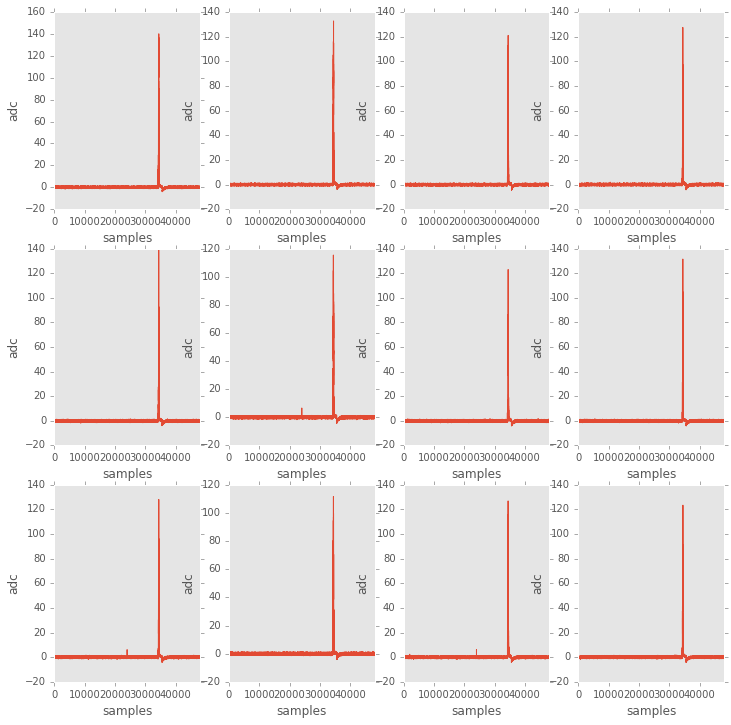

Press a key...


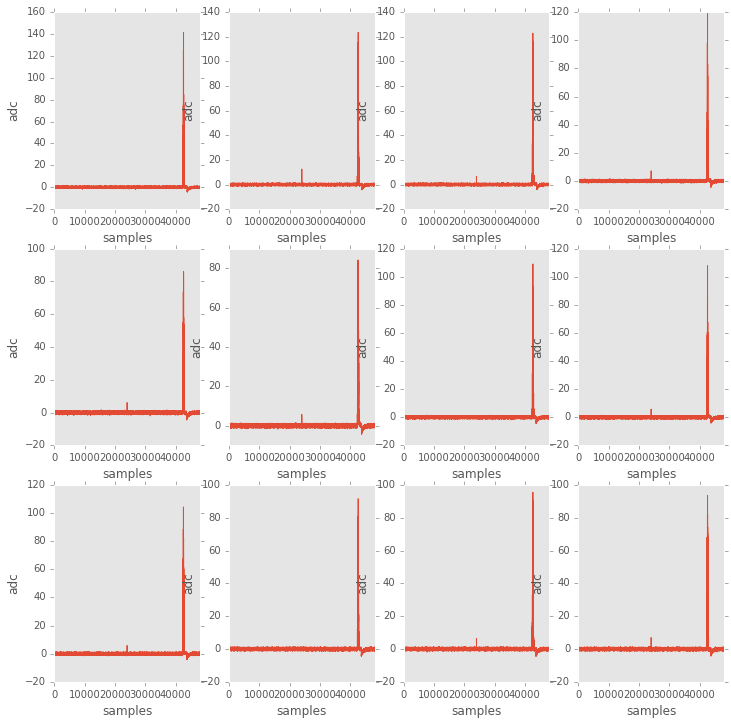

Press a key...


In [354]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

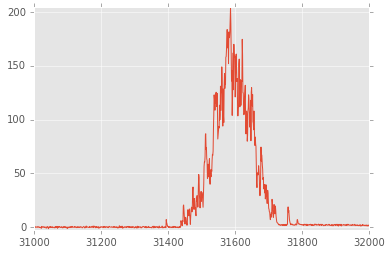

In [355]:
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=31000, signal_end=32000, offset=1)

In [359]:
def ana_wf():
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")
    pmtcwf = h5f.root.RD.pmtcwf
    plts(pmtcwf[0, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[0, 0], signal_start=5750, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=3280, signal_end=5000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)
    plt.show()
    h5f.close()

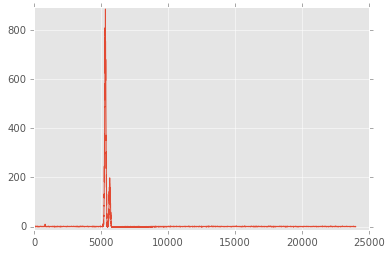

Press a key...


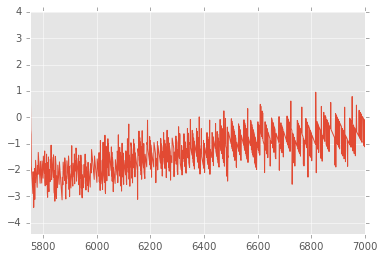

Press a key...


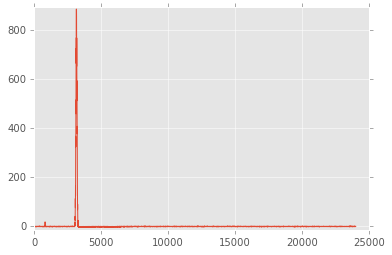

Press a key...


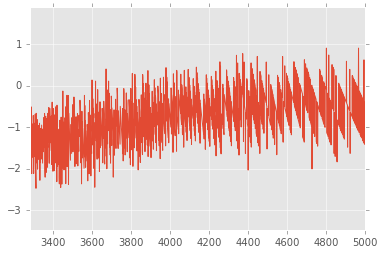

Press a key...


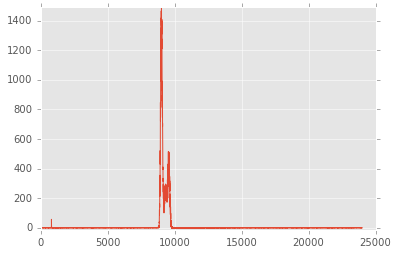

Press a key...


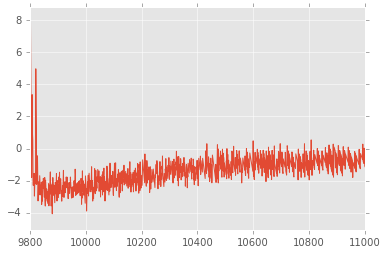

In [360]:
ana_wf()

In [361]:
h5f.close()